## Content Based Image Retrieving

In [1]:
import os
import glob
import cv2
import pickle
import faiss
import numpy as np
import matplotlib.pyplot as plt

### Helper Functions

In [2]:
# Function to label feature vectors based on their source category (car, cricket_ball, cricket_bat)
def label_feature_vectors(descriptors, labels):
    labeled_descriptors = []
    for label, des_list in zip(labels, descriptors):
        labeled_descriptors.extend([(label, des) for des in des_list if des is not None])
    return labeled_descriptors

In [3]:
# Function to build a Faiss index
def build_index(labeled_descriptors):
    feature_vectors = np.array([des for label, des in labeled_descriptors])
    labels = np.array([label for label, des in labeled_descriptors])

    index = faiss.IndexFlatL2(feature_vectors.shape[1])  # L2 distance (Euclidean distance) for similarity search

    index.train(feature_vectors)

    index.add(feature_vectors)

    return index

In [4]:
# cPath = './Dataset/Cricket_bat/'
# paths = os.listdir(cPath)
# paths

### Load the Data

In [5]:
# Get the complete path of all the images from three folders and then concatenate it to the list paths
ball_paths = glob.glob('./Dataset/Cricket_ball/*.jpg') + glob.glob('./Dataset/Cricket_ball/*.jfif')
car_paths = glob.glob('./Dataset/Car/*.jpg') + glob.glob('./Dataset/Car/*.jfif')
bat_paths = glob.glob('./Dataset/Cricket_bat/*.jpg')

paths = ball_paths + car_paths + bat_paths

paths

['./Dataset/Cricket_ball\\ball1.jpg',
 './Dataset/Cricket_ball\\ball10.jpg',
 './Dataset/Cricket_ball\\ball100.jpg',
 './Dataset/Cricket_ball\\ball101.jpg',
 './Dataset/Cricket_ball\\ball102.jpg',
 './Dataset/Cricket_ball\\ball103.jpg',
 './Dataset/Cricket_ball\\ball104.jpg',
 './Dataset/Cricket_ball\\ball105.jpg',
 './Dataset/Cricket_ball\\ball106.jpg',
 './Dataset/Cricket_ball\\ball107.jpg',
 './Dataset/Cricket_ball\\ball108.jpg',
 './Dataset/Cricket_ball\\ball109.jpg',
 './Dataset/Cricket_ball\\ball11.jpg',
 './Dataset/Cricket_ball\\ball110.jpg',
 './Dataset/Cricket_ball\\ball111.jpg',
 './Dataset/Cricket_ball\\ball112.jpg',
 './Dataset/Cricket_ball\\ball113.jpg',
 './Dataset/Cricket_ball\\ball114.jpg',
 './Dataset/Cricket_ball\\ball115.jpg',
 './Dataset/Cricket_ball\\ball116.jpg',
 './Dataset/Cricket_ball\\ball117.jpg',
 './Dataset/Cricket_ball\\ball118.jpg',
 './Dataset/Cricket_ball\\ball119.jpg',
 './Dataset/Cricket_ball\\ball12.jpg',
 './Dataset/Cricket_ball\\ball120.jpg',
 './D

## To rename the images in folder

In [6]:
# Assign labels to the datasets (0: Cricket_ball, 1: Car, 2: Cricket_bat)
labels = [0] * len(ball_paths) + [1] * len(car_paths) + [2] * len(bat_paths)

### ORB Feature Descriptor

In [7]:
orb = cv2.ORB_create()

images = []
descriptors = []

for path in paths:
    img = cv2.imread(path, 0)
    kp, des = orb.detectAndCompute(img, None)  # Compute keypoints and descriptors
    images.append(img)
    descriptors.append(des)

In [8]:
# images
descriptors

[array([[205,  86,  83, ..., 216, 224,  96],
        [ 17, 149,  59, ...,  74, 197, 222],
        [189, 105, 239, ..., 189,  88, 212],
        ...,
        [234,  50, 132, ...,  68, 175, 148],
        [ 37, 173,  96, ..., 239, 218, 164],
        [153, 156,  23, ..., 192, 129,  57]], dtype=uint8),
 array([[239,  99, 192, ..., 255, 122, 132],
        [173, 236, 177, ..., 171,  82, 164],
        [ 89,  71,  85, ..., 230,  64,  45],
        ...,
        [229, 243, 141, ..., 177, 138, 208],
        [160, 178, 141, ..., 106,   7, 112],
        [ 92, 222,  47, ..., 244, 172, 124]], dtype=uint8),
 array([[ 24, 159,  10, ..., 222, 188, 253],
        [ 12, 255, 144, ..., 124, 141, 222],
        [ 24, 156, 210, ..., 200, 228,  93],
        ...,
        [  2, 155,  98, ...,   4, 175, 223],
        [ 10, 217, 147, ...,  20, 173, 219],
        [ 11,  76, 170, ...,  28,  61, 223]], dtype=uint8),
 array([[ 75, 253,  96, ...,  87, 207,  95],
        [ 13, 253,  18, ..., 255, 172, 221],
        [191, 24

### Labeling and Indexing

In [9]:
labeled_descriptors = label_feature_vectors(descriptors, labels)

In [10]:
# Build Faiss index
index = build_index(labeled_descriptors)

# Save the Faiss index and labeled descriptors for future use
faiss.write_index(index, 'faiss_index.index')

with open('labeled_descriptors.pkl', 'wb') as labeled_descriptors_file:
    pickle.dump(labeled_descriptors, labeled_descriptors_file)

In [11]:
query_img = cv2.imread('./Dataset/Car/car101.jpg', 0)
_, query_des = orb.detectAndCompute(query_img, None)

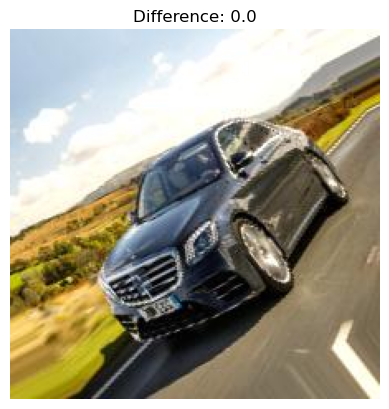

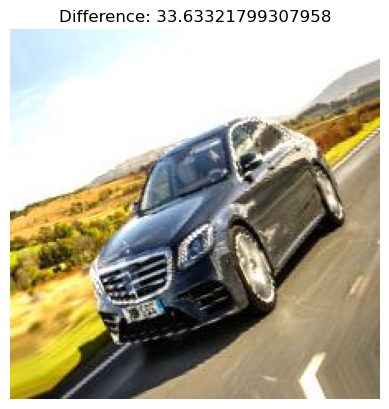

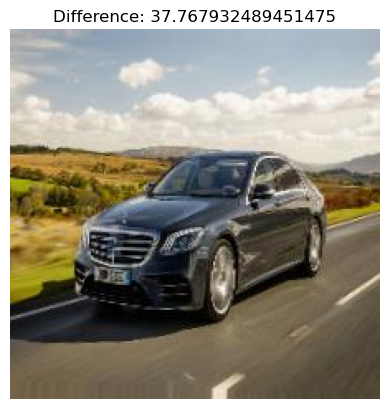

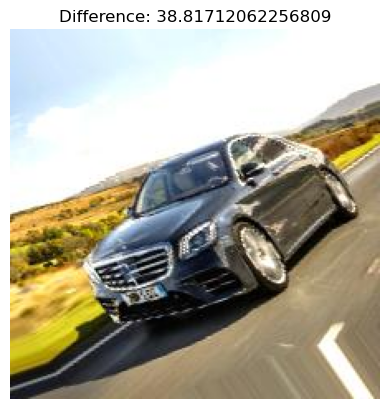

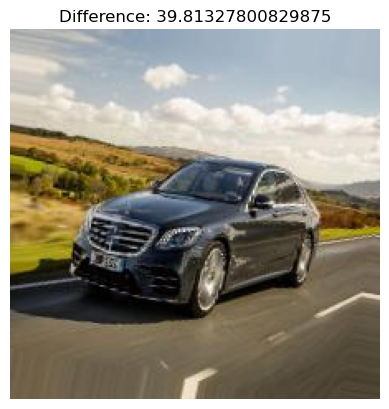

In [20]:
if query_des is not None and len(query_des) > 0:
    distances = {}

    for idx, des in enumerate(descriptors):
        if des is not None and des.shape[1] == query_des.shape[1]:  # Check if shapes are compatible
            # Compute Hamming distance for binary descriptors
            bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
            matches = bf.match(query_des, des)
            if matches:
                dist = sum([match.distance for match in matches]) / len(matches)
                distances[idx] = dist

    sorted_distances = dict(sorted(distances.items(), key=lambda item: item[1]))

    # Display the retrieved images
    limit = 0
    for idx, sim in sorted_distances.items():
        path = paths[idx]
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        plt.title('Difference: ' + str(sim))
        plt.axis('off')
        plt.show()
        limit += 1
        if limit == 5:
            break
else:
    print("Query descriptor is empty or could not be computed.")

### Evaluating Similarity with Precision and Recall

In [19]:
# Retrieve indices of similar images
indices = list(sorted_distances.keys())
# Define relevant labels for each category
relevant_labels = [1] * len(car_paths) + [0] * (len(ball_paths) + len(bat_paths))

# Calculate precision and recall
relevant_labels_retrieved = [relevant_labels[idx] for idx in indices]
num_relevant_retrieved = sum(relevant_labels_retrieved)
precision = num_relevant_retrieved / len(indices)
recall = num_relevant_retrieved / len(car_paths)  # Total relevant images for car category

print("Precision:", precision)
print("Recall:", recall)

Precision: 0.4718954248366013
Recall: 1.0
